In this notebook, we created our LDA model on top of the dataframe with the discourses about the Amazon.

In [ ]:
import pandas as pd
import numpy as np

from collections import Counter
import pickle

import gensim
from gensim.models import Phrases, LdaModel, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import plotly_express as px
from plotly.offline import init_notebook_mode
init_notebook_mode() # required to reload the figures upon re-opening the notebook

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
df = pd.read_csv("amazon_clean_discourses.tsv", sep="\t", encoding="utf-8")
df = df.drop(["discourse_link", "session", "original_discourse", "phase", "state"], axis=1)

# create a year colunm
df['year'] = pd.DatetimeIndex(df['date']).year

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index(['date'], drop=False)

# tokenizing column
df["tokenized"] = [gensim.utils.simple_preprocess(line) for line in df["tokenized"]]

In [ ]:
# building bigram
bigram = gensim.models.Phrases(df["tokenized"], min_count=5, threshold=90)
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(text):
    return [bigram_mod[doc] for doc in text]

# adding a column in our df
df["bigrams"] = make_bigrams(df["tokenized"])

# now, we get all the discourses and convert them to a list of strings.
# the output is a list containing list of strings for each document (discourse)
bigrams = df['bigrams'].values

In [ ]:
# Lemmatization pre-processing step here is optional. At least for Portuguese, we faced some 
# inconsistencies that affected our general results. For example, the Portuguese word for "river"
# was transformed to "laugh" because they look semantically similar

'''def lemma(speeches):
    speeches_out = []
    for word in speeches:
        doc = nlp(" ".join(word))
        speeches_out.append([token.lemma_ for token in doc])
    return speeches_out

%%time
speech_lemma = lemma(bigrams)'''

In [ ]:
# instead of using BOW, we can build a corpus based on a TF-IDF model

'''
texts = bigrams
corpus = [dictionary.doc2bow(text) for text in texts]

# create tf-idf model object on corpus and save it to 'tfidf'
tfidf = TfidfModel(corpus)

# apply transformation to the entire corpus and call it 'corpus_tfidf'
corpus_tfidf = tfidf[corpus]
'''

In [ ]:
# dictionary: tokens will be translated to unique ids, we may do this by transforming the text to a list of words and passing it to the method
dictionary = Dictionary(bigrams)

# no_above: keep tokens which are contained in no more than X% documents, this means that tokens appearing in more than 60% will be removed
# no_below: keep tokens which are contained in at least Y documents; less than 5 documents
# so we'll filter out words that occur less than 5 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_above=0.6, no_below=5)

# store the dictionary, for future reference
# with open('amazon_dictionary.pkl', 'wb') as f:
#    pickle.dump(dictionary, f)
        
# with open('amazon_dictionary.pkl', 'rb') as f:
#    dictionary = pickle.load(f)

# get the token and ids
# print(dictionary.token2id)

# the corpus object contains both the word id and the frequency with which it appears in each doc. 
# to create a BOW corpus, we need to feed the tokenized list of words to the dictionary after it has been updated
texts = bigrams
corpus = [dictionary.doc2bow(text) for text in texts]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 50440
Number of documents: 14602


In [ ]:
# create a dictionary and then convert it to a df that shows each word in the corpus and its frequency
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if dictionary[idx] in dict_corpus:
      dict_corpus[dictionary[idx]] += freq
    else:
       dict_corpus[dictionary[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])
dict_df = dict_df.sort_values('freq', ascending=False)
dict_df.head(10)

,freq
região,27457
nacional,24906
federal,24883
desenvolvimento,24017
projeto,17082
recursos,14318
população,13904
pará,13195
trabalho,12487
lei,12430


**Coherence Measures**

Let’s take a quick look at different coherence measures, and how they are calculated:

* C_umass is based on document co-occurrence counts, a one-preceding segmentation and a logarithmic conditional probability as a confirmation measure.

* C_v measure is based on a sliding window, one-set segmentation of the top word and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity. It measures the degree of semantic similarity between high-scoring words in each topic (and then average across topics).

Looking at the graphs we choose to go with 12 topics, although no certain answer can be given.

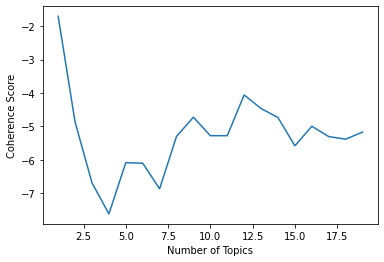

CPU times: user 8min 53s, sys: 4min 4s, total: 12min 58s
Wall time: 8min 35s


In [ ]:
# calculating the coherence score using u_mass:

%%time
topics = []
score = []

for i in range(1,20,1):
   lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, random_state=25, chunksize=100, passes=30, per_word_topics=True)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())

plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

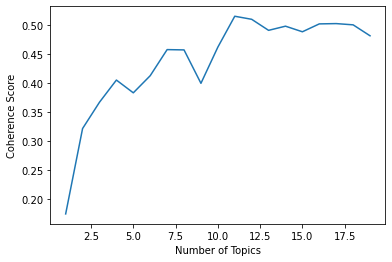

CPU times: user 20min 54s, sys: 9min 20s, total: 30min 14s
Wall time: 20min 1s


In [ ]:
# calculating the coherence score using c_v:

%%time
topics = []
score = []

for i in range(1,20,1):
   lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, random_state=25, chunksize=100, passes=30, per_word_topics=True)
   cm = CoherenceModel(model=lda_model, texts=bigrams, corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())

plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

LDA is the most used technique and is considered to be consistent as it is likely to provide more "coherent" topics. Let's instantiate the LDA Topic Modelling.

In [ ]:
# optimal model
%%time
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary, 
                     num_topics=12, 
                     random_state=25, 
                     chunksize=100,
                     passes=30, 
                     per_word_topics=True)

In [ ]:
# save model in pickle format to working directory
# lda_model.save("lda_amazon.pkl")

# load model back into your workspace from working directory
lda_model = gensim.models.LdaModel.load("lda_amazon.pkl")

There are two metrics to evaluate how good the model is:

`Perplexity:` statistical measure of how well a probability model predicts a sample. The lower the better.

`Coherence Score:` average/median of the pairwise word-similarity scores of the words in the topic, the higher the better.

In [ ]:
%%time
coherence_lda = CoherenceModel(model=lda_model, texts=bigrams, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_lda.get_coherence()

print('Coherence Score:', coherence_lda)
print('Perplexity:', lda_model.log_perplexity(corpus)) 

Coherence Score: 0.5043683611105895
Perplexity: -9.197549146442471
CPU times: user 2min 27s, sys: 22.2 s, total: 2min 49s
Wall time: 2min 27s


To determine the number of topics most appropriate, we ran LDA with different numbers of topics (20, 15, 12, 10) to get a feel for the problem. Through manual inspection, 12 seemed to produce the most interpretable topics, so that is what I settled for this research. Using gensim's Python wrapper, inferring the parameters is then straightforward, albeit slow. Inference took about 1 hour so we'd recommend trying it on Google Colab using the GPU.

In [ ]:
for i in range(12):
    print('Topic {}: '.format(i+1) + ', '.join([term for term, _ in lda_model.show_topic(i)]))

Topic 1: pará, obras, quilômetros, construção, obra, belém, região, mato_grosso, infraestrutura, correios
Topic 2: defesa, pandemia, soberania, nacional, segurança, exército, polícia, militares, forças_armadas, segurança_pública
Topic 3: petrobras, mundo, economia, crise, energia, combustível, aumento, redução, econômica, países
Topic 4: agricultura, produção, rondônia, agricultores, agricultura_familiar, rural, agronegócio, alimentos, hectares, produtores
Topic 5: meio_ambiente, ambiental, desmatamento, ambientais, queimadas, mundo, floresta, desenvolvimento, nacional, proteção
Topic 6: terra, terras, pará, famílias, trabalhadores, violência, amapá, campo, reforma_agrária, situação
Topic 7: educação, saúde, programa, desenvolvimento, nacional, recursos, federal, trabalho, social, universidade
Topic 8: lei, projeto, medida_provisória, câmara, nacional, congresso, comissão, partido, constituição, república
Topic 9: indígenas, povos_indígenas, mulheres, indígena, luta, direitos, história

In [ ]:
def show_topic(lda_model, topic_number, topn): 
    """ldamodel, the topic (int) and the number of terms to be printed."""
    for term, freq in lda_model.show_topic(topic_number, topn=topn):
      print(u'{:20} {:.3f}'.format(term, round(freq, 3)))

show_topic(lda_model, 2, 20)

petrobras            0.012
mundo                0.011
economia             0.011
crise                0.010
energia              0.009
combustível          0.008
aumento              0.007
redução              0.007
econômica            0.006
países               0.006
empresas             0.006
dilma                0.005
preço                0.005
renda                0.005
mercado              0.005
lula                 0.004
conta                0.004
investimentos        0.004
cop                  0.004
medidas              0.004


**Word Clouds**

Visualizing the terms as word clouds is also a good option to present topics. Below we create word clouds for each topic. The font sizes of words show their relative weights in the topic.

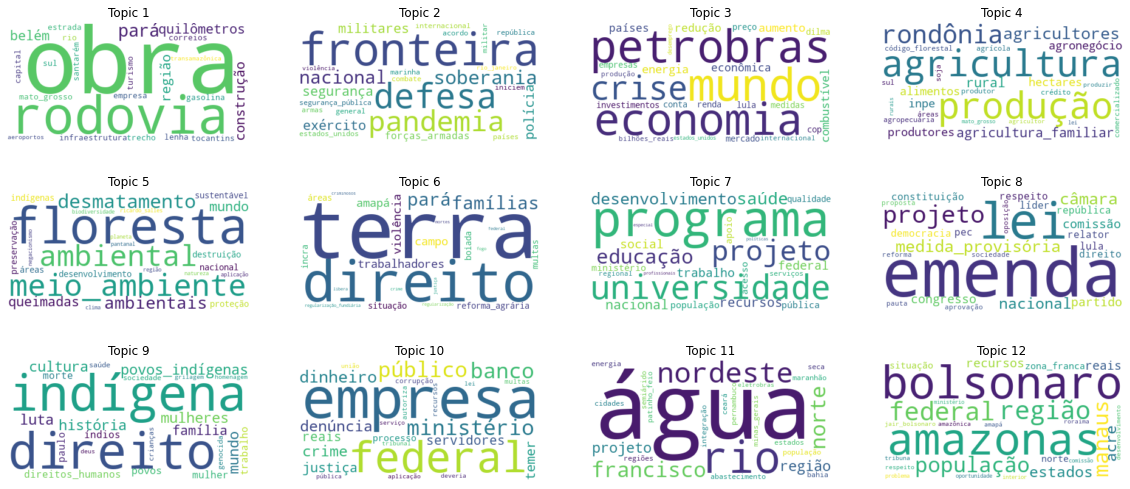

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=25)] for n in range(0, lda_model.num_topics)]

# display 20 terms for a topic in a single df row:
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms per Topic'], 
                         index=['Topic ' + str(t) for t in range(1, lda_model.num_topics+1)] )

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="viridis", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# create subplots for each topic
for i in range(12):
    wc.generate(text=topics_df["Terms per Topic"][i])    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.


*   Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
*   Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
*   Red bars give the estimated number of times a given term was generated by a given topic. The word with the longest red bar is the word that is used the most by the discourses belonging to that topic.
*   The further the bubbles are away from each other, the more different they are.

A good topic model will have big and non-overlapping bubbles scattered throughout the chart

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

# save as html
pyLDAvis.save_html(vis, '/html/ldavis_amazon.html')

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
# the most important words per topic 
topics = lda_model.show_topics(num_topics=12, formatted=False)
data_flat = [w for w_list in bigrams for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

words = pd.DataFrame(out, columns=['word', 'topic', 'importance', 'word_count'])
words.head(6)

,word,topic,importance,word_count
0,pará,0,0.033476,13195
1,obras,0,0.014225,5142
2,quilômetros,0,0.011029,4047
3,construção,0,0.009659,6166
4,obra,0,0.008519,2870
5,belém,0,0.008470,2116


Let's create a df with the documents and probability of each topic. Then we'll merge with our original dataframe, calling the year, coalition, and region variables.

In [ ]:
# let's create yearly time-series weights for each topic inputing the original amazon df
df_time = df.reset_index(drop=True)
df_time['doc_id'] = df_time.index
df_time['date'] = pd.DatetimeIndex(df_time['date'])

In [ ]:
# setup df
lda_df = pd.DataFrame(columns = ['topic', 'prob_weight', 'doc_id'])

# the loop extracts topic proportions (ranging from 0 to 1) for all the topics for every 
# individual document and places them into a df with a doc-id key for merging topic 
# proportion information with other our df corpus

for i in range(0, len(corpus)):
    weights = lda_model[corpus[i]][0] # get only the 1st list, which is the topic probability
    weights_df = pd.DataFrame(weights, columns = ['topic', 'prob_weight'])
    weights_df['doc_id'] = i
    lda_df = lda_df.append(weights_df)

    # relabel topics
    lda_df['topic'] = lda_df['topic'].astype(str).replace({'0':'road projects', '1':'national sovereignty', '2':'foreign affairs', 
                                                           '3':'agricultural expansion', '4':'environmental protection', '5':'land rights', 
                                                           '6':'social welfare', '7':'procedural', '8':'indigenous rights', 
                                                           '9':'criminal complaints', '10':'water transposition', '11':'amazon’s development'})

# merge with df_time, then we'll have weights for each topic according to time, coalition and region
df_topic_weight = pd.merge(lda_df, df_time[['doc_id', 'year', 'coalition', 'region', 'speaker', 
                                            'party', 'clean_discourse']], on='doc_id', how='left')

# remove procedural and criminal complaints topics
df_topic_weight = df_topic_weight.drop(df_topic_weight [df_topic_weight .topic == "procedural"].index)
df_topic_weight = df_topic_weight.drop(df_topic_weight [df_topic_weight .topic == "criminal complaints"].index)

# add presidential term
def president(row):  
    if row['year'] <= 2002:
        return 'fhc'
    elif row['year'] >= 2003 and row['year'] <= 2010:
        return 'lula'
    elif row['year'] >= 2011  and row['year'] <= 2016:
        return 'dilma'
    elif row['year'] >= 2017  and row['year'] <= 2018:
        return 'temer'
    return 'bolsonaro'

df_topic_weight['president'] = df_topic_weight.apply(lambda row: president(row), axis=1)

# save df
df_topic_weight.to_csv("lda_amazon_weights.tsv", sep="\t")
df_topic_weight.head(6)

,topic,prob_weight,doc_id,year,coalition,region,speaker,party,clean_discourse,president
0,road projects,0.021940,0,2000,opposition,north,nilton capixaba,ptb,"Sr. Presidente, Sras. e Srs. Deputados, na sem...",fhc
1,foreign affairs,0.052164,0,2000,opposition,north,nilton capixaba,ptb,"Sr. Presidente, Sras. e Srs. Deputados, na sem...",fhc
2,agricultural expansion,0.327571,0,2000,opposition,north,nilton capixaba,ptb,"Sr. Presidente, Sras. e Srs. Deputados, na sem...",fhc
3,social welfare,0.242749,0,2000,opposition,north,nilton capixaba,ptb,"Sr. Presidente, Sras. e Srs. Deputados, na sem...",fhc
5,indigenous rights,0.062300,0,2000,opposition,north,nilton capixaba,ptb,"Sr. Presidente, Sras. e Srs. Deputados, na sem...",fhc
7,amazon’s development,0.131531,0,2000,opposition,north,nilton capixaba,ptb,"Sr. Presidente, Sras. e Srs. Deputados, na sem...",fhc


In [ ]:
# check topic distribution per coalition
topic_distribution = df_topic_weight.groupby(['topic']).size().reset_index().rename(columns={0:'count'})

# the number of documents for each topic according to the coalitions
plot_topic_distribution = px.bar(topic_distribution,
                                x="count",
                                y="topic",
                                color_discrete_sequence=px.colors.qualitative.Prism,
                                title="Topic distribution across documents",
                                labels={"count":"count of topics", "index":"topic", "coalition":""},
                                orientation="h",
                                width=900, 
                                height=700,
                                ).update_yaxes(categoryorder="total ascending")

plot_topic_distribution.update_layout(legend=dict(orientation="h",
                                                  yanchor="bottom",
                                                  y=1.02,
                                                  xanchor="right",
                                                  x=1),
                                      barmode="group")

plot_topic_distribution.update_xaxes(tickangle=360)  
plot_topic_distribution.show(renderer="colab")

In [ ]:
# check topic distribution per coalition
topic_distribution = df_topic_weight.groupby(['topic', 'coalition']).size().reset_index().rename(columns={0:'count'})

# the number of documents for each topic according to the coalitions
plot_topic_distribution = px.bar(topic_distribution,
                                x="count",
                                y="topic",
                                color="coalition",
                                title=" Topic distribution across documents",
                                color_discrete_map={"coalition": "rgb(118,78,159)",  "opposition": "rgb(153,201,69)"},
                                labels={"count":"count of topics", "index":"topic", "coalition":""},
                                orientation="h",
                                width=900, 
                                height=700,
                                ).update_yaxes(categoryorder="total ascending")

plot_topic_distribution.update_layout(legend=dict(orientation="h",
                                                  yanchor="bottom",
                                                  y=1.02,
                                                  xanchor="right",
                                                  x=1),
                                      barmode="group")

plot_topic_distribution.update_xaxes(tickangle=360)  
plot_topic_distribution.show()

**What are the dominant topic and its percentage contribution in each document?**

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords.

This way we can see which document belongs predominantly to which topic.

In [ ]:
def format_topics(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    # get main topic in each doc
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, percentage contribution and keywords for each doc
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ['dominant_topic', '%_contribution', 'topic_keywords']

    # add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)

# let's wrap it up:
df_topics = format_topics(lda_model, corpus, bigrams)
df_topics.columns = ['dominant_topic', '%_contribution', 'topic_keywords', 'text']
df_topics['doc_id'] = df_topics.index

# we then merge the previous the 'df_topics' to create a final per-doc df
df_dominant_time = pd.merge(df_topics, df_time[['doc_id', 'year', 'coalition', 'region', 'speaker', 'party', 'clean_discourse']], on='doc_id', how='left')

# rename topic labels
df_dominant_time['dominant_topic']= df_dominant_time['dominant_topic'].astype(str).replace({'0.0':'road projects', '1.0':'national sovereignty', '2.0':'foreign affairs', '3.0':'agricultural expansion', 
                                                                                            '4.0':'environmental protection', '5.0':'land rights', '6.0':'social welfare', '7.0':'procedural', 
                                                                                            '8.0':'indigenous rights', '9.0':'criminal complaints', '10.0':'water transposition', '11.0':'amazon’s development'})

# remove the topics procedural and criminal complaints
df_dominant_time = df_dominant_time.drop(df_dominant_time[df_dominant_time.dominant_topic == "procedural"].index)
df_dominant_time = df_dominant_time.drop(df_dominant_time[df_dominant_time.dominant_topic == "criminal complaints"].index)


#df_dominant_time.to_csv("df_dominant.tsv", sep="\t")
df_dominant_time.head(10)

,dominant_topic,%_contribution,topic_keywords,text,doc_id,year,coalition,region,speaker,party,clean_discourse
0,agricultural expansion,0.3276,"agricultura, produção, rondônia, agricultores,...","[gabinete, câmara, diretor, ceplac, comissão, ...",0,2000,opposition,north,nilton capixaba,ptb,"Sr. Presidente, Sras. e Srs. Deputados, na sem..."
1,land rights,0.2150,"terra, terras, pará, famílias, trabalhadores, ...","[solidariedade, amapá, joão_capiberibe, psb, p...",1,2000,opposition,northeast,sérgio novais,psb,"Sr. Presidente, Sras. e Srs. Deputados, prime..."
2,indigenous rights,0.3352,"indígenas, povos_indígenas, mulheres, indígena...","[tribuna, protesto, rede_globo, televisão, vei...",2,2000,opposition,north,marcos afonso,pt,"Sr. Presidente, Sras. e Srs. Deputados, venho..."
3,environmental protection,0.1629,"meio_ambiente, ambiental, desmatamento, ambien...","[incoerente, órgão, federal, fiscaliza, homem,...",3,2000,coalition,north,expedito júnior,dem,"Sr. Presidente, Sras. e Srs. Deputados, pode ..."
4,amazon’s development,0.3127,"bolsonaro, amazonas, região, federal, populaçã...","[tribuna, período, expediente, pensava, falari...",4,2000,opposition,north,silas câmara,ptb,"Sr. Presidente, Sras. e Srs. Deputados, é com..."
5,amazon’s development,0.3931,"bolsonaro, amazonas, região, federal, populaçã...","[paulo_paim, somamos, pedro_fernandes, silas_c...",5,2000,opposition,north,eurípedes miranda,pdt,"Sr. Presidente, Sras. e Srs. Parlamentares, g..."
6,national sovereignty,0.1988,"defesa, pandemia, soberania, nacional, seguran...","[tribuna, balanço, trabalho, desenvolvemos, co...",6,2000,opposition,northeast,fernando ferro,pt,"Sr. Presidente, Sras. e Srs. Deputados, venho..."
7,social welfare,0.5287,"educação, saúde, programa, desenvolvimento, na...","[seminário, brasília, banco, mundial, bird, ni...",7,2000,coalition,midwest,juquinha,psdb,"Sr. Presidente, Sras. e Srs. Deputados, duran..."
8,road projects,0.4130,"pará, obras, quilômetros, construção, obra, be...","[tribuna, pará, população, oeste, paraense, vi...",8,2000,coalition,north,nilson pinto,psdb,"Sr. Presidente, Sras. e Srs. Parlamentares, a..."
9,road projects,0.7292,"pará, obras, quilômetros, construção, obra, be...","[viagem, comunicações, pimenta_veiga, rodovia,...",9,2000,coalition,north,nicias ribeiro,psdb,"Sr. Presidente, Sras. e Srs. Deputados, venho..."


In [ ]:
# the number of documents for each topic according to the president coalition
coalition = px.bar(df_dominant_time.groupby(['dominant_topic', "coalition"]).size().reset_index().rename(columns={0:'count'}),
                   x="count",
                   y="dominant_topic",
                   color="coalition",
                   labels={"coalition": "", 
                           "count":"count of topics",
                           "dominant_topic": "dominant topic"},
                   color_discrete_map={"coalition": "rgb(118,78,159)", "opposition": "rgb(153,201,69)"},
                   orientation="h",
                   width=900, 
                   height=700,
                   title="Dominant Topic Distribution Across Documents"
                  ).update_yaxes(categoryorder="total ascending")

coalition.update_layout(legend=dict(orientation="h",
                                    yanchor="bottom",
                                    y=1.02,
                                    xanchor="right",
                                    x=1),
                        barmode="group")
            

coalition.update_xaxes(tickangle=-360)  
coalition.show()

We can use the pandas groupby function on the Dominant Topic column and get the document counts for each topic and its percentage in the corpus.

In [ ]:
df_dominant = df_dominant_time.groupby('dominant_topic').agg(count=('dominant_topic', np.size), perc=('dominant_topic', np.size)).reset_index()
df_dominant['perc'] = df_dominant['perc'].apply(lambda row: round((row) / len(corpus), 3))
df_dominant

,dominant_topic,count,perc
0,agricultural expansion,457,0.031
1,amazon’s development,2114,0.145
2,environmental protection,1649,0.113
3,foreign affairs,1380,0.095
4,indigenous rights,1472,0.101
5,land rights,671,0.046
6,national sovereignty,550,0.038
7,road projects,794,0.054
8,social welfare,2531,0.173
9,water transposition,300,0.021


In [ ]:
dominant_count = px.bar(df_dominant,
                        x="dominant_topic",
                        y="count",
                        title="Number of Dominant Topics under Amazon Rainforest Discourses",
                        color_discrete_sequence=px.colors.qualitative.Bold,
                        labels={"dominant_topic":"topic"},
                        width=700, 
                        height=700,
                        ).update_xaxes(categoryorder="total descending")

dominant_count.update_xaxes(tickangle=-90) 
dominant_count.show()

**How did topics change over time?**

While pyLDAvis gives us a good overall picture of the model data, we need to further manipulate the data in order to track change over time across different years.

The first item in the variable weights is a list of tuples and you get topic distributions for each document (remember: one document can have multiple topics, so this is what we will see now). Since it stores the topic distributions for all documents, we can create a dataframe to analyze the data.

`Source: https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/`

In [ ]:
# groupby year and topic, summing the prob_weight
df_avg = df_topic_weight.groupby(['year', 'topic']).agg({'prob_weight':'sum'}).reset_index()

# get number of docs per year, it must result the corpus len
total_docs = df_topic_weight.groupby('year')['doc_id'].apply(lambda x: len(x.unique())).reset_index() 
total_docs.columns = ['year', 'docs']

# merge the dfs
df_avg = df_avg.merge(total_docs, on='year', how="left")

# the mean per topic: normalizing the weights for each document, so that they total to '1'
df_avg['average_weight'] = df_avg['prob_weight']/df_avg['docs']
df_avg.head(3)

,year,topic,prob_weight,docs,average_weight
0,2000,agricultural expansion,6.902210,164,0.042087
1,2000,amazon’s development,20.272076,164,0.123610
2,2000,environmental protection,16.832687,164,0.102638


In [ ]:
# this plot highlights the topic presence over time, it is a time series comparison of yearly topic proportions for the topics in the Amazon Rainforest discourse corpus
# the graph is useful to interpret topic distributions over time and how it changed

topic = px.line(df_avg,
                x="year",
                y="average_weight", 
                color="topic",
                title="Yearly average of normalized weight per topics on the Amazon Rainforest discourses",
                color_discrete_sequence=px.colors.qualitative.Prism,
                width=1000, 
                height=600,
                labels={"average_weight":"topic prevalence", "x":"year", "topic":""})

#topic.update_layout(legend=dict(orientation="h",
#                                yanchor="bottom",
#                                y=1.02,
#                                xanchor="right",
#                                x=1))

topic.write_html("html/LDA_topic_overtime.html")
topic.show(renderer="colab")

In [ ]:
# what about the coalitions? can we know each topic presence over time considering the coalition and opposition?

# groupby year topic and coalition, summing the prob_weight
df_avg_co = df_topic_weight.groupby(['year', 'topic', 'coalition']).agg({'prob_weight':'sum'}).reset_index()

# merge with the number of docs per year and calculate the mean per topic: normalizing the weights for each document, so that they total to '1'
df_avg_co = df_avg_co.merge(total_docs, on='year', how="left")
df_avg_co['average_weight'] = df_avg_co['prob_weight'] / df_avg_co['docs']

# save
# df_avg_co.to_csv("df_avg_co.tsv", sep="\t")
df_avg_co.head(5)

,year,topic,coalition,prob_weight,docs,average_weight
0,2000,agricultural expansion,coalition,2.326429,164,0.014186
1,2000,agricultural expansion,opposition,4.575781,164,0.027901
2,2000,amazon’s development,coalition,7.206429,164,0.043942
3,2000,amazon’s development,opposition,13.065647,164,0.079669
4,2000,environmental protection,coalition,9.881167,164,0.060251


In [ ]:
# this plot highlights the topic presence over time per coalition:
topic_co = px.line(df_avg_co,
                   x="year",
                   y="average_weight",
                   color="topic",
                   facet_col="coalition",
                   title="Yearly average of normalized weight per topics on the Amazon rainforest discourses per coalition",
                   color_discrete_sequence=px.colors.qualitative.Prism,
                   width=1400, 
                   height=600,
                   labels={"average_weight":"topic prevalence", "x":"year", "topic":"", "coalition":""})

#topic_co.update_layout(legend=dict(orientation="h",
#                                   yanchor="bottom",
#                                   y=1.02,
#                                   xanchor="right",
#                                   x=1))

topic_co.write_html("html/LDA_topic_coalition_overtime.html")
topic_co.show()

In [23]:
# let's look closely to particular topics
topic_plot = px.line(df_avg_co[df_avg_co["topic"] == "foreign affairs"],
                     x="year",
                     y="average_weight",
                     color="coalition",
                     title="Yearly average of normalized weight of foreign affairs topic",
                     color_discrete_map={"coalition": "rgb(118,78,159)", "opposition": "rgb(153,201,69)"},
                     width=700, 
                     height=700,
                     #groupnorm='percent', # sets the normalization for the sum of the stackgroup
                     labels={"average_weight":"topic prevalence", "x":"year", "coalition":""})

topic_plot.update_layout(legend=dict(orientation="h",
                                yanchor="bottom",
                                y=1.02,
                                xanchor="right",
                                x=1))

topic_plot.show()

We will use t-SNE to reduce the dimensionality of our topic embedding to just 2 dimensions. The first step is using our LDA model to infer topics for all of the documents in our dataset and storing the results in a tabular format.

In [ ]:
# we then merge the previous dfs to create a final per-doc df
df_tsne = pd.merge(df_topics, df_time[['doc_id', 'year', 'coalition', 'region', 'party']], 
                   on='doc_id', how='left')

In [ ]:
topic_n = 12

cols = ["id", "year", "coalition", "region", "party", *range(topic_n), "dominant_topic"] 

rows = []
for i, doc in enumerate(corpus):
    id = df_tsne.doc_id[i]
    year = df_tsne.year[i]
    cltn = df_tsne.coalition[i]
    region = df_tsne.region[i]
    party = df_tsne.party[i]
    pred = [pred[1] for pred in lda_model.get_document_topics(doc, minimum_probability=0)]
    rows.append([id, year, cltn, region, party, *pred, np.argmax(pred)])

discourse_topics = pd.DataFrame(rows, columns=cols)

# rename topic labels
discourse_topics['dominant_topic'] = discourse_topics['dominant_topic'].astype(str).replace({'0':'road projects', '1':'national sovereignty', '2':'foreign affairs', '3':'agricultural expansion', 
                                                                                             '4':'environmental protection', '5':'land rights', '6':'social welfare', '7':'procedural', 
                                                                                             '8':'indigenous rights', '9':'criminal complaints', '10':'water transposition', '11':'amazon’s development'})

# add presidential term
def president(row):  
    if row['year'] <= 2002:
        return 'fhc'
    elif row['year'] >= 2003 and row['year'] <= 2010:
        return 'lula'
    elif row['year'] >= 2011  and row['year'] <= 2016:
        return 'dilma'
    elif row['year'] >= 2017  and row['year'] <= 2018:
        return 'temer'
    return 'bolsonaro'

discourse_topics['president'] = discourse_topics.apply(lambda row: president(row), axis=1)

# remove procedural and criminal complaints topics
discourse_topics = discourse_topics.drop(discourse_topics[discourse_topics.dominant_topic == "procedural"].index)
discourse_topics = discourse_topics.drop(discourse_topics[discourse_topics.dominant_topic == "criminal complaints"].index)

# save df
discourse_topics.to_csv("discourse_topics_tsne.tsv", sep="\t")
# discourse_topics.head(3)

In [ ]:
# then we will train the t-SNE model:
tsne = TSNE(n_components=2, verbose=1, random_state=25, init='pca', perplexity=100)
tsne_lda = tsne.fit_transform(discourse_topics[list(range(topic_n))])

# to better vis, let's make it a df
disc_tsne = discourse_topics.copy()
disc_tsne['tsne_0'] = tsne_lda[:, 0]
disc_tsne['tsne_1'] = tsne_lda[:, 1]
# disc_tsne.head(3)

tsne_fig = px.scatter(disc_tsne,
                      x="tsne_0",
                      y="tsne_1", 
                      color="dominant_topic",
                      title="t-SNE clustering of Amazon rainforest LDA Topics",
                      hover_name="dominant_topic",
                      symbol='coalition',
                      symbol_sequence=['circle', 'cross'],
                      hover_data=["id", "year", "party", "coalition", "region"],
                      color_discrete_map={"amazon’s development":"rgb(95,70,144)", "social welfare":"rgb(128,186,90)",
                                          "environmental protection":"rgb(15,133,84)", "land rights":"rgb(242,183,1)",
                                          "indigenous rights":"rgb(225,124,5)", "agricultural expansion":"rgb(204,80,62)", 
                                          "foreign affairs":"rgb(29,105,150)", "national sovereignty":"rgb(231,63,116)",
                                          "road projects":"rgb(165,170,153)", "water transposition":"rgb(56,166,165)"},
                      category_orders={"dominant_topic":["amazon’s development", "social welfare", "environmental protection", 
                                                         "land rights", 'indigenous rights', "agricultural expansion", "foreign affairs", 
                                                         "national sovereignty", "road projects", "water transposition"]},
                      opacity=0.7,
                      width=1200,
                      height=800,
                      labels={"dominant_topic":"dominant topic"},
                      animation_frame="president"
                      )

tsne_fig.update_yaxes(title='tsne_0')
tsne_fig.update_xaxes(title='tsne_1')

tsne_fig.write_html("html/LDA_coalition_slider.html")
tsne_fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 11916 samples in 0.017s...
[t-SNE] Computed neighbors for 11916 samples in 2.808s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11916
[t-SNE] Computed conditional probabilities for sample 2000 / 11916
[t-SNE] Computed conditional probabilities for sample 3000 / 11916
[t-SNE] Computed conditional probabilities for sample 4000 / 11916
[t-SNE] Computed conditional probabilities for sample 5000 / 11916
[t-SNE] Computed conditional probabilities for sample 6000 / 11916
[t-SNE] Computed conditional probabilities for sample 7000 / 11916
[t-SNE] Computed conditional probabilities for sample 8000 / 11916
[t-SNE] Computed conditional probabilities for sample 9000 / 11916
[t-SNE] Computed conditional probabilities for sample 10000 / 11916
[t-SNE] Computed conditional probabilities for sample 11000 / 11916
[t-SNE] Computed conditional probabilities for sample 11916 / 11916
[t-SNE] Mean sigma: 0.086927


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.205681
[t-SNE] KL divergence after 1000 iterations: 1.962269


In [ ]:
tsne_fig = px.scatter(disc_tsne,
                      x="tsne_0",
                      y="tsne_1", 
                      color="dominant_topic",
                      title="t-SNE clustering of Amazon rainforest LDA topics",
                      hover_name="dominant_topic",
                      symbol='coalition',
                      symbol_sequence=['circle', 'cross'],
                      hover_data=["id", "year", "party", "coalition", "region"],
                      color_discrete_map={"amazon’s development":"rgb(95,70,144)", "social welfare":"rgb(128,186,90)",
                                          "environmental protection":"rgb(15,133,84)", "land rights":"rgb(242,183,1)",
                                          "indigenous rights":"rgb(225,124,5)", "agricultural expansion":"rgb(204,80,62)", 
                                          "foreign affairs":"rgb(29,105,150)", "national sovereignty":"rgb(231,63,116)",
                                          "road projects":"rgb(165,170,153)", "water transposition":"rgb(56,166,165)"},
                      category_orders={"dominant_topic":["amazon’s development", "social welfare", "environmental protection", 
                                                         "land rights", 'indigenous rights', "agricultural expansion", "foreign affairs", 
                                                         "national sovereignty", "road projects", "water transposition"]},
                      opacity=0.7,
                      width=1200,
                      height=800,
                      labels={"dominant_topic":"dominant topic"}
                      )

tsne_fig.update_yaxes(title='tsne_0')
tsne_fig.update_xaxes(title='tsne_1')

tsne_fig.write_html("html/LDA_coalition_overall.html")
tsne_fig.show(renderer="colab")